In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time
import sys
import os
import networkx as nx
import re
import scipy.stats

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

from parliament.utils import merge_utterance_paragraphs

# combine information and plot graphs

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

def plot_network(G_party, filename, pos_from_gephi=False, G_pos=None, filter_nodes=False,
                 label=None, edge_width_factor=20, party_name=None, legend_pos='lower left',
                label_y_offset=20, label_highlight_colors=None):
    
    if pos_from_gephi:
        x = nx.get_node_attributes(G_pos, 'x')
        y = nx.get_node_attributes(G_pos, 'y')

        nx.set_node_attributes(G_party, x, 'x')
        nx.set_node_attributes(G_party, y, 'y')

    if filter_nodes:
        f = nx.get_node_attributes(G_pos, 'filter')
        nx.set_node_attributes(G_party, f, 'filter')

        print("applying filter: {}".format(f))

        nodes = list(G_party.nodes())
        for node in nodes:
            if not node in f.keys():
                G_party.remove_node(node)

    #if pos_from_gephi or filter_nodes:
    #    nx.write_graphml(G_party, graph_file)

    # remove disconnected nodes
    #G_party.remove_node('15')

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    if pos_from_gephi:
        pos = {node: [x[node], y[node]] for node in x.keys()}
    else:
        pos=nx.spring_layout(G_party)
        x = {}
        y = {}

        for key, value in pos.items():
            x[key] = value[0]
            y[key] = value[1]

    scores = nx.get_node_attributes(G_party, "totalscores")
    max_score = max(list(scores.values()))

    node_size = [50. + 2000.*scores[node]/max_score for node in G_party.nodes()]

    node_color = list(nx.degree_centrality(G_party).values())
    #node_color = list(nx.betweenness_centrality(G_party).values())
    #node_color = list(nx.eigenvector_centrality(G_party).values())

    cmap_name = 'Blues'

    nx.draw_networkx_nodes(G_party, pos, node_size=node_size,
                           node_color=node_color, #node_color='#A0CBE2',
                           alpha=1, # alpha of node colors
                           linewidths=1, edgecolors='k', # width and color of node edges
                           cmap=plt.get_cmap(cmap_name), #vmax=2100., vmin=0,
                           with_labels=False)
    edge_width = 1. + edge_width_factor*np.array(list(nx.get_edge_attributes(G_party, "weight").values()))
    
    edge_color_dict = {"gruene": "#64A12D", "spd": "#EB001F", "cducsu": "#000000",
                   "linke": "#8C3473", "fdp": "#FFED00", "afd": "#0088FF", None: 'k' }

    nx.draw_networkx_edges(G_party, pos, width=edge_width, alpha = 0.5, edge_color=edge_color_dict[party_name])
    #nx.draw_networkx_edges(G_party, pos, width=2., edge_color=edge_width, edge_cmap=plt.get_cmap('Greens'))

    # plot node labels
    labels = nx.get_node_attributes(G_party,"label")
    # central alignment of labels
    #nx.draw_networkx_labels(G_party,pos, labels,font_size=16)
    #ax.set_xlim([-720, 900])

    for i, node in enumerate(G_party.nodes()):
        distance_scale = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
        # left alignment of labels
        #ax.text(x[node] + distance_scale, #+ 0.02*node_size[i],
         #       y[node], labels[node], verticalalignment='center', fontsize=16)
        if label_highlight_colors:
            highlight_color = label_highlight_colors[node]
        else:
            highlight_color = (1., 1., 1.)
            
        ax.text(x[node], y[node] - label_y_offset - 0.02*node_size[i], labels[node],
                verticalalignment='top', horizontalalignment='center', fontsize=14,
                bbox=dict(boxstyle="square,pad=0.1",
                   ec='none',
                   fc=highlight_color,
                   alpha=0.5
                   ))
    
    # plot title label
    if label:
        ax.text(-0.05, 0.92, label,
            horizontalalignment='left',
            verticalalignment='bottom',
            transform=ax.transAxes,
            fontsize=32)
        
    plt.axis('off')

    cmap = plt.cm.get_cmap(cmap_name)
    colors = cmap(np.arange(cmap.N))

    # inset for colormap
    if legend_pos == 'lower right':
        bbox_inset1 = (.8, .1, .2, .1)
        bbox_inset2 = (.8, .0, .2, .08)
        legend_box_pos = [0.78, -0.02]
    elif legend_pos == 'lower left':
        bbox_inset1 = (.01, .1, .2, .1)
        bbox_inset2 = (.01, .0, .2, .08)
        legend_box_pos = [0., -0.02]
    elif legend_pos == 'upper left':
        bbox_inset1 = (0.01, 0.9, 0.2, 0.1)
        bbox_inset2 = (0.01, 0.8, 0.2, 0.08)
        legend_box_pos = [0., 0.78]
    elif legend_pos == 'upper right':
        bbox_inset1 = (0.8, 0.9, 0.2, 0.1)
        bbox_inset2 = (0.8, 0.8, 0.2, 0.08)
        legend_box_pos = [0.78, 0.78]
    else:
        print("invalid legend_pos:", legend_pos)
    
    axinset = inset_axes(ax, width="100%", height="100%",
                    bbox_to_anchor=bbox_inset1,
                    bbox_transform=ax.transAxes)
    axinset.set_xticks([])
    axinset.set_yticks([])
    axinset.imshow([colors], extent=[0, 10, 0, 1])
    axinset.set_title('degree centrality')

    # inset for node size
    #axinset = inset_axes(ax, width="30%", height="20%", loc=4)
    axinset2 = inset_axes(ax, width="100%", height="100%",
                    bbox_to_anchor=bbox_inset2,
                    bbox_transform=ax.transAxes)
    axinset2.set_xticks([])
    axinset2.set_yticks([])
    axinset2.set_title('topic score')
    for i in range(1, 4):
        c = mpatches.Circle([i, 0], radius=i*0.1, facecolor='w', edgecolor='k')
        axinset2.add_patch(c)
    plt.axis('off')
    plt.axis('equal')
    
    # box around inset
    fancybox = mpatches.FancyBboxPatch(legend_box_pos, 0.22, 0.24, transform=ax.transAxes, fill=False,
                                       edgecolor='k', linewidth=2, clip_on=False,
                                       boxstyle=mpatches.BoxStyle("Round", pad=0.01))
    ax.add_patch(fancybox)

    #print_network_characteristics(G_party)
    #compute_network_measures(G_party)

    fig.savefig(filename, dpi=300, bbox_inches='tight')

In [20]:
# settings, set up and load topic classification

run_id = 2350
percentile = 80
correlation_method = 'event_sync' #'spearman'

save_dir = '../plots/topic_analysis_{}/topic_correlations/'.format(run_id)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

topic_dir = "../plots/topic_analysis_{}/".format(run_id)
topic_classification = pd.read_csv(topic_dir + '0_topic_list_run{}_labeled.csv'.format(run_id), index_col=0)
topic_classification #['classification']    

,label,label short,classification,label Finn,Discussion with Jan,Jan,Jan.1,Jan period,top words weighted,top words avg,top words peak,score pct,score
184089,common terms,common terms,procedural and general politics,stopwords,NaN,stop words,NaN,NaN,"tun, wirklich, wiss, red, gar, darub, natur, r...","tun, wiss, wirklich, red, gar, darub, natur, r...","ding, vielleicht, wirklich, gar, wiss, seh, we...",10.672064,419821.116446
184090,procedural,procedural,procedural and general politics,procedural,NaN,procedural,NaN,NaN,"darauf, haus, darub, darf, bereich, punkt, bun...","darauf, darub, haus, bereich, punkt, debatt, b...","haus, darauf, darf, darub, entscheid, lass, bu...",9.348242,367744.157874
184081,economic policy,economic policy,economy and budget,economic policy,NaN,Wirtschaftspolitik/ -entwicklung,NaN,NaN,"wirtschaft, unternehm, entwickl, deutsch, mark...","unternehm, wirtschaft, deutsch, deutschland, m...","wirtschaft, entwickl, bereich, wirtschaftspoli...",5.492435,216063.202495
184105,federal government,federal government,procedural and general politics,procedural 2,NaN,Bundesregierung,Procedere,NaN,"bundeskanzl, partei, regier, deutsch, sozialde...","bundeskanzl, deutsch, partei, deutschland, reg...","regier, bundeskanzl, volk, partei, sozialdemok...",4.037749,158838.262969
184102,policy statements,policy statements,procedural and general politics,economic system ?,NaN,NaN,Grundsatzreden,NaN,"deutsch, volk, bundesregier, freiheit, wirtsch...","deutsch, volk, bundesregier, freiheit, deutsch...","deutsch, deutschland, gemeinsam, wirtschaft, f...",3.989937,156957.446933
184106,budget,budget,economy and budget,budget,NaN,Haushaltspolitik/ Bundeshaushalt,NaN,1 bis 5/6 - hält sich aber,"milliard, million, bund, haushalt, hoh, rund, ...","milliard, bund, million, hoh, rund, haushalt, ...","million, milliard, bund, haushalt, hoh, bundes...",3.783282,148827.974002
184086,European Coal & Steel Community,ECSC,international and regional,German-French economic policy,NaN,Europäische (Wirtschafts-)gemeinschaft,Deutsch-französische Wirtschaftszusammenarbeit,NaN,"europa, deutsch, vertrag, franzos, frankreich,...","europa, union, gemeinschaft, deutsch, vertrag,...","deutsch, schumanplan, deutschland, vertrag, fr...",3.685528,144982.504003
184098,international cooperation,international cooperation,international and regional,Europe,international,Internationale Politik,Europäische Politk,NaN,"europa, gemeinsam, international, deutschland,...","europa, gemeinsam, international, staat, gemei...","deutschland, wichtig, international, gemeinsam...",3.627137,142685.511866
184108,energy supply mix,energy supply mix,energy,energy policy,NaN,Energiepolitik,look at topic score development and explain,NaN,"energi, erneuerbar, energiepolit, kohl, bundes...","energi, erneuerbar, kohl, energiepolit, energi...","energiepolit, bundesregier, energi, kohl, kern...",3.422472,134634.299691
184097,procedural 2,procedural 2,procedural and general politics,Mixed ?,Gesetzgebung?,Gesetzgebung,EWG highlighted,NaN,"gesetz, wirtschaft, bundesregier, entwurf, bun...","gesetz, wirtschaft, bundesregier, entwurf, bun...","ewg, rechtzeit, gesetz, endgult, wirtschaft, b...",3.160606,124332.949316


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


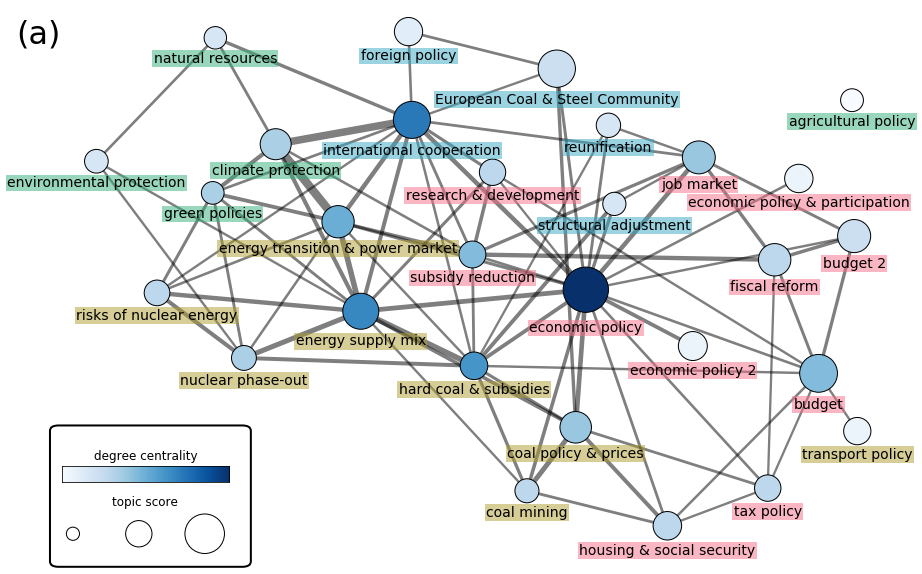

In [21]:
# plot and save network for paper plot

pos_from_gephi = True

if pos_from_gephi:
    G_pos = nx.read_graphml(os.path.join(save_dir, 'gephi_pos_new_80pct.graphml'))
else:
    G_pos=None

graph_file = os.path.join(save_dir,
                    'topic_correlations_run{}_all_pct{}_{}.graphml'.format(run_id, percentile, correlation_method))
G_plot = nx.read_graphml(graph_file)

# colors for label highlighting
labels = nx.get_node_attributes(G_plot,"label")
label_to_class = topic_classification.set_index('label')['classification']
class_to_color = dict(zip(['economy and budget', 'energy', 'environment', 'international and regional'],
                          sns.color_palette('husl', 5)[:4]))
highlight_color_dict = {node: class_to_color[label_to_class[label]] for node, label in labels.items()}
highlight_color_dict

plot_network(G_plot, os.path.join(save_dir,
                    'topic_correlations_run{}_all_pct{}_{}.png'.format(run_id, percentile, correlation_method)),
                        pos_from_gephi=pos_from_gephi, G_pos=G_pos, filter_nodes=False, label='(a)',
                    edge_width_factor=200, legend_pos='lower left', label_y_offset=15,
                     label_highlight_colors=highlight_color_dict)

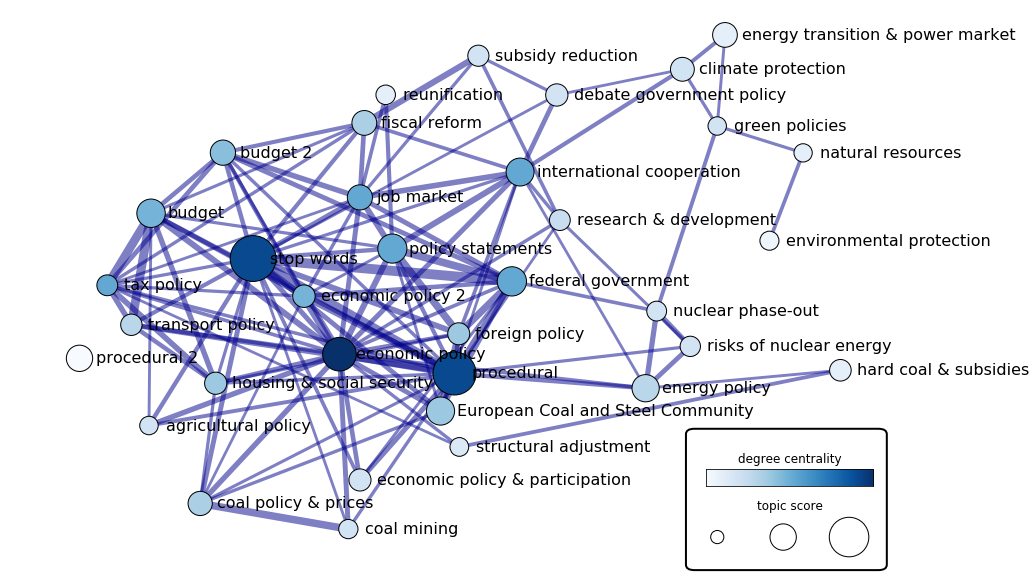

In [17]:
# combine information for plotting

# to use this option, load exported graph file in gephi,
# run positioning algorith (e.g. Force Atlas 2 + Label Adjustment)
# and export as gephi_all_pos.graphml
pos_from_gephi = True
# to use this option add a new boolean attribute to the graph called "filter"
filter_nodes = False

if pos_from_gephi:
    G_pos = nx.read_graphml(os.path.join(save_dir, 'gephi_all_pos.graphml'))
else:
    G_pos=None

party_iter = True
pp_iter = False

if party_iter:
    party_list = [None] #[None, "gruene", "spd", "cducsu", "linke", "fdp", "afd"]

    for party_name in party_list:
        
        graph_file = os.path.join(save_dir, 'topic_correlations_run{}_party_{}_pct80.graphml'.format(run_id, party_name))
        G_party = nx.read_graphml(graph_file)

        plot_network(G_party, os.path.join(save_dir, "graph_run_{}_party_{}_pct80".format(run_id, party_name)),
                        pos_from_gephi=pos_from_gephi, G_pos=G_pos, filter_nodes=filter_nodes, label=party_name)


if pp_iter:
    labels = ["1949 - 1969", "1969 - 1990", "1990 - 2005", "2005 - 2019"]

    for i, periods in enumerate(period_sets):

        graph_file = os.path.join(save_dir, 'topic_correlations_run{}_period_{}-{}.graphml'.format(run_id,
                                                                            min(periods), max(periods)))
        G_pp = nx.read_graphml(graph_file)

        plot_network(G_pp, os.path.join(save_dir, "graph_run_{}_period_{}-{}".format(run_id,
                                                                            min(periods), max(periods))),
                         pos_from_gephi=pos_from_gephi, G_pos=G_pos, filter_nodes=filter_nodes, label=labels[i])


# spider graphs of centrality measures according to categories

In [22]:
#sns.reset_orig()
sns.set()

def spider_graph(stats, labels, title=None, ax=None, ymax=None, label_colors=None):

    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    stats=np.concatenate((stats,[stats[0]]))
    angles=np.concatenate((angles,[angles[0]]))

    if not ax:
        fig=plt.figure()
        ax = fig.add_subplot(111, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    if ymax:
        tick_pos = np.arange(0, ymax, 10)
        ax.set_yticks(tick_pos)
        ax.set_yticklabels([str(i) for i in tick_pos], color="grey", size=8)
        ax.set_ylim(0, ymax)

    ax.set_thetagrids(angles * 180/np.pi, labels)
    
    rotate_ticklabels(ax, label_colors=label_colors)
    
    if title:
        ax.set_title(title)
    ax.grid(True)

    
def rotate_ticklabels(ax, label_colors=None):
    
    plt.gcf().canvas.draw()
    if len(ax.get_xticklabels()) == 5:
        angles = [0, 270, 0, 90]   
    else:
        angles = np.linspace(0,2*np.pi,len(ax.get_xticklabels())+1)
        angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi
        angles = np.rad2deg(angles)
    labels = []
    i=0
    for label, angle in zip(ax.get_xticklabels(), angles):
        x,y = label.get_position()
        if label_colors:
            lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                          ha=label.get_ha(), va=label.get_va(), fontsize=10,
                          bbox=dict(boxstyle="square,pad=0.1",
                           ec='none',
                           fc=label_colors[i],
                           alpha=0.5
                           ))
            i += 1
        else:
            lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                          ha=label.get_ha(), va=label.get_va(), fontsize=10)
        lab.set_rotation(angle)
        labels.append(lab)
    ax.set_xticklabels([])

    
def get_centrality_sums(G, topic_classification, classes):
    
    nx.set_node_attributes(G, dict(nx.degree(G, weight='weight')), 'weighted degree')
    nx.set_node_attributes(G, dict(nx.degree(G)), 'degree')
    nx.set_node_attributes(G, dict(nx.betweenness_centrality(G)), 'betweenness')

    centrality_measures = ['degree', 'weighted degree', 'betweenness']
    centrality_sums = pd.DataFrame(0, columns=centrality_measures, index=classes)

    for cl in classes:
        topic_labels = topic_classification[topic_classification['classification'] == cl]['label'].values
        for node_id, attr in G.nodes(data=True):
            if attr['label'] in topic_labels:
                for cm in centrality_measures:
                    centrality_sums.loc[cl, cm] += attr[cm]
                    
    for cm in centrality_measures:
        centrality_sums['pct ' + cm] = 100 * centrality_sums[cm] / centrality_sums[cm].sum()
        
    return centrality_sums

,degree,weighted degree,betweenness,pct degree,pct weighted degree,pct betweenness
economy and budget,67,0.683430,0.542793,40.361446,35.527957,51.943239
energy,56,0.733828,0.289835,33.734940,38.147896,27.736086
environment,18,0.236064,0.023690,10.843373,12.271748,2.267028
international and regional,25,0.270317,0.188656,15.060241,14.052399,18.053647


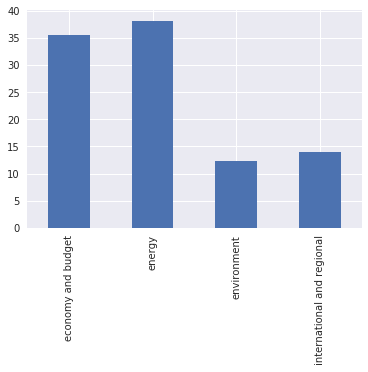

In [23]:
# for one network:
graph_file = os.path.join(save_dir, 'topic_correlations_run{}_all_pct{}_{}.graphml'.format(run_id, percentile, correlation_method))

G = nx.read_graphml(graph_file)

classes = ["economy and budget", "energy", "environment", "international and regional"]
centrality_sums = get_centrality_sums(G, topic_classification, classes)
centrality_sums['pct weighted degree'].plot.bar()
centrality_sums

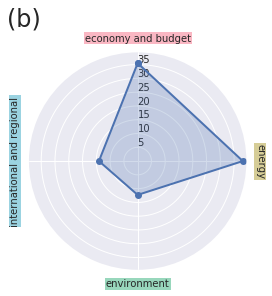

In [30]:
# spider for network of all documents

class_colors = sns.color_palette('husl', 5)[:4]
spider_graph(centrality_sums['pct weighted degree'].values, classes, label_colors=class_colors)

ax = plt.gca()
ax.text(-0.1, 1.1, '(b)',
            horizontalalignment='left',
            verticalalignment='bottom',
            transform=ax.transAxes,
            fontsize=24)

fig = plt.gcf()
fig.savefig(os.path.join(save_dir, "graph_run_{}_aggregate_degree_spiders_all".format(run_id, correlation_method)), bbox_inches="tight")

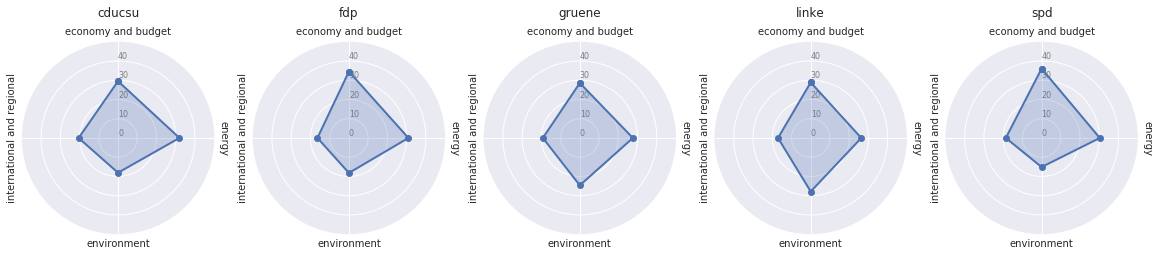

In [68]:
# for parties:

classes = ["economy and budget", "energy", "environment", "international and regional"]
parties = ["cducsu", "fdp", "gruene", "linke", "spd"]

mpl.rcParams['axes.titlepad'] = 15.

fig, axs = plt.subplots(1, len(parties), subplot_kw=dict(polar=True), figsize=(4*len(parties),4))

for i, party_name in enumerate(parties):
    
    graph_file = os.path.join(save_dir, 'topic_correlations_run{}_party_{}_pct{}_{}_1990.graphml'.format(run_id,
                                                                                                         party_name,
                                                                                                         percentile,
                                                                                                         correlation_method))
        
    G_party = nx.read_graphml(graph_file)

    nx.set_node_attributes(G_party, dict(nx.degree(G_party, weight='weight')), 'weighted degree')
    nx.set_node_attributes(G_party, dict(nx.degree(G_party)), 'degree')
    nx.set_node_attributes(G_party, dict(nx.betweenness_centrality(G_party)), 'betweenness')

    centrality_measures = ['degree', 'weighted degree', 'betweenness']
    centrality_sums = pd.DataFrame(0, columns=centrality_measures, index=classes)

    for cl in classes:
        topic_labels = topic_classification[topic_classification['classification'] == cl]['label'].values
        for node_id, attr in G_party.nodes(data=True):
            if attr['label'] in topic_labels:
                for cm in centrality_measures:
                    centrality_sums.loc[cl, cm] += attr[cm]
                    
    for cm in centrality_measures:
        centrality_sums['pct ' + cm] = 100 * centrality_sums[cm] / centrality_sums[cm].sum()
        
    spider_graph(centrality_sums['pct degree'].values, classes, ax=axs[i],
                 title=party_name, ymax=50)

fig.savefig(os.path.join(save_dir, "graph_run_{}_aggregate_degree_spiders_parties_{}_1990".format(run_id, correlation_method)), bbox_inches="tight")

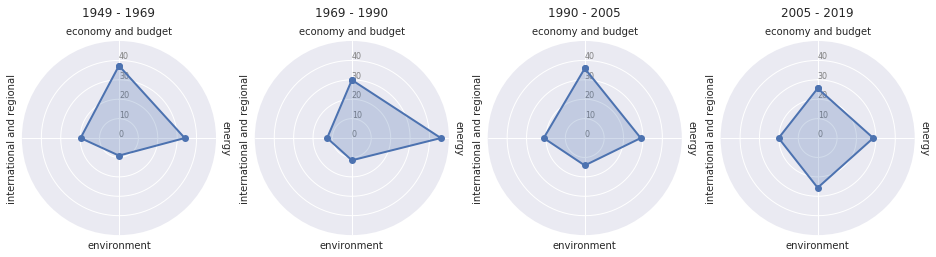

In [71]:
# for period sets:

classes = ["economy and budget", "energy", "environment", "international and regional"]

subplot_labels = ["1949 - 1969", "1969 - 1990", "1990 - 2005", "2005 - 2019"]

fig, axs = plt.subplots(1, len(period_sets), subplot_kw=dict(polar=True), figsize=(4*len(period_sets),4))

for i, periods in enumerate(period_sets):
    
    graph_file = os.path.join(save_dir, 'topic_correlations_run{}_period_{}-{}_pct{}_{}.graphml'.format(run_id,
                                                                            min(periods), max(periods),
                                                                            percentile,
                                                                            correlation_method))
        
    G_party = nx.read_graphml(graph_file)

    nx.set_node_attributes(G_party, dict(nx.degree(G_party, weight='weight')), 'weighted degree')
    nx.set_node_attributes(G_party, dict(nx.degree(G_party)), 'degree')
    nx.set_node_attributes(G_party, dict(nx.betweenness_centrality(G_party)), 'betweenness')

    centrality_measures = ['degree', 'weighted degree', 'betweenness']
    centrality_sums = pd.DataFrame(0, columns=centrality_measures, index=classes)

    for cl in classes:
        topic_labels = topic_classification[topic_classification['classification'] == cl]['label'].values
        for node_id, attr in G_party.nodes(data=True):
            if attr['label'] in topic_labels:
                for cm in centrality_measures:
                    centrality_sums.loc[cl, cm] += attr[cm]
                    
    for cm in centrality_measures:
        centrality_sums['pct ' + cm] = 100 * centrality_sums[cm] / centrality_sums[cm].sum()
        
    spider_graph(centrality_sums['pct degree'].values, classes, ax=axs[i],
                 title=subplot_labels[i], ymax=50)

fig.savefig(os.path.join(save_dir, "graph_run_{}_aggregate_degree_spiders_periods_{}".format(run_id, correlation_method)), bbox_inches="tight")

In [63]:
# todo:
# - sensitivity of thresholds
# - significance tests


In [170]:
%%bash
zip -r plots/topic_analysis_2350.zip plots/topic_analysis_2350

updating: plots/topic_analysis_2350/ (stored 0%)
updating: plots/topic_analysis_2350/0_topic_list_run2350_labeled.csv (deflated 70%)
updating: plots/topic_analysis_2350/0_topic_list+peak_topwords_run2350.xlsx (deflated 5%)
updating: plots/topic_analysis_2350/.ipynb_checkpoints/ (stored 0%)
updating: plots/topic_analysis_2350/topic_evolution_run2350_aggregate.png (deflated 6%)
updating: plots/topic_analysis_2350/party_proportions_run_2350_selection.png (deflated 33%)
updating: plots/topic_analysis_2350/topic_evolution_shares_run2350_wo_procedural_barplot_simple.png (deflated 19%)
updating: plots/topic_analysis_2350/topic_evolution_scores_run2350_all.png (deflated 10%)
updating: plots/topic_analysis_2350/topic_evolution_shares_run2350_all.png (deflated 9%)
updating: plots/topic_analysis_2350/time+party/ (stored 0%)
updating: plots/topic_analysis_2350/time+party/party_scores_run_2350_topic_184087.png (deflated 24%)
updating: plots/topic_analysis_2350/time+party/party_proportions_run_2350_

# testing and old code

In [23]:
for node_id, attr in G_party.nodes(data=True):
    print(node_id, attr)

0 {'label': 'environmental protection', 'id': 184079, 'totalscores': 147.722803398875}
1 {'label': 'debate government policy', 'id': 184080, 'totalscores': 2565.47499831048}
2 {'label': 'economic policy', 'id': 184081, 'totalscores': 335.120402217308}
3 {'label': 'agricultural policy', 'id': 184082, 'totalscores': 16.8927096181933}
4 {'label': 'green policies', 'id': 184083, 'totalscores': 91.1684108298073}
5 {'label': 'reunification', 'id': 184084, 'totalscores': 232.816837906663}
6 {'label': 'coal mining', 'id': 184085, 'totalscores': 0.71}
7 {'label': 'European Coal and Steel Community', 'id': 184086, 'totalscores': 75.7273378843524}
8 {'label': 'subsidy reduction', 'id': 184087, 'totalscores': 252.880612189229}
9 {'label': 'nuclear phase-out', 'id': 184088, 'totalscores': 306.375449281092}
10 {'label': 'stop words', 'id': 184089, 'totalscores': 1580.7272333005}
11 {'label': 'procedural', 'id': 184090, 'totalscores': 119.692468628946}
12 {'label': 'research & development', 'id': 184

In [14]:
list(G_party.nodes(data=True))

[('0',
  {'id': 184079,
   'label': 'environmental protection',
   'totalscores': 147.722803398875}),
 ('1',
  {'id': 184080,
   'label': 'debate government policy',
   'totalscores': 2565.47499831048}),
 ('2',
  {'id': 184081, 'label': 'economic policy', 'totalscores': 335.120402217308}),
 ('3',
  {'id': 184082,
   'label': 'agricultural policy',
   'totalscores': 16.8927096181933}),
 ('4',
  {'id': 184083, 'label': 'green policies', 'totalscores': 91.1684108298073}),
 ('5',
  {'id': 184084, 'label': 'reunification', 'totalscores': 232.816837906663}),
 ('6', {'id': 184085, 'label': 'coal mining', 'totalscores': 0.71}),
 ('7',
  {'id': 184086,
   'label': 'European Coal and Steel Community',
   'totalscores': 75.7273378843524}),
 ('8',
  {'id': 184087,
   'label': 'subsidy reduction',
   'totalscores': 252.880612189229}),
 ('9',
  {'id': 184088,
   'label': 'nuclear phase-out',
   'totalscores': 306.375449281092}),
 ('10', {'id': 184089, 'label': 'stop words', 'totalscores': 1580.72723

In [15]:
list(G_party.edges(data=True))

[('0', '12', {'weight': 0.5924275907439535}),
 ('0', '20', {'weight': 0.348280020535281}),
 ('0', '25', {'weight': 0.3515090429143934}),
 ('0', '28', {'weight': 0.3988510033440545}),
 ('1', '3', {'weight': 0.3322826737052749}),
 ('1', '5', {'weight': 0.29464615944632394}),
 ('1', '15', {'weight': 0.24572153968036575}),
 ('1', '18', {'weight': 0.22087003051493334}),
 ('1', '21', {'weight': 0.3035868979117506}),
 ('1', '23', {'weight': 0.1932920278081769}),
 ('1', '30', {'weight': 0.17948873340948313}),
 ('1', '33', {'weight': 0.208714088460816}),
 ('2', '3', {'weight': 0.2174454488233128}),
 ('2', '5', {'weight': 0.22610491858385526}),
 ('2', '7', {'weight': 0.25655178137362167}),
 ('2', '22', {'weight': 0.3558635659759508}),
 ('2', '27', {'weight': 0.17829342176786897}),
 ('2', '29', {'weight': 0.2725137543117447}),
 ('3', '5', {'weight': 0.2417439067633256}),
 ('3', '18', {'weight': 0.3944463492259749}),
 ('3', '22', {'weight': 0.44095997698913364}),
 ('3', '33', {'weight': 0.17811327

In [ ]:
# generate graphs for parliamentary periods

new_labels = False
threshold0 = False

for period in range(1,20):

    corr, pvalues = corr_topics(run_id, period_list=[period])

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, 90)
        G = get_graph(corr, threshold)
    
    topic_ids = nx.get_node_attributes(G, 'id')
    
    scores = {}
    topic_labels = nx.get_node_attributes(G, 'label')
    for node_id, topic_label in topic_labels.items():
        scores[node_id] = float(df_period_scores[topic_label][period])
        
    nx.set_node_attributes(G, scores, 'totalscores')
    
    if new_labels:
        node_labels = {}
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
            
        nx.set_node_attributes(G, node_labels, 'label')
    
    filename = os.path.join(save_dir, 'topic_correlations_run{}_period_{}.graphml'.format(run_id, period))
    nx.write_graphml(G, filename)
    print("saved graph in {}".format(filename))

In [ ]:
# test duplicate removal while preserving order

from collections import OrderedDict

terms = Term.objects.filter(topicterm__topic=topic).order_by('-topicterm__score').values('title', 'topicterm__score')[:stat.periods.all().count() * no_top_words]

odict = OrderedDict({})

for t in terms:
    if not t['title'] in odict.keys():
        odict[t['title']] = t['topicterm__score']

#list(OrderedDict.fromkeys(items))
print(odict)
print(len(odict))
